- Load the houseprices data from Thinkful's database.
- Split your data into train and test sets.
- Estimate your model from the previous checkpoint in the train set. Assess the goodness of fit of your model.
- Predict the house prices in the test set, and evaluate the performance of your model using the metrics we mentioned in this checkpoint.
- Is the performance of your model satisfactory? Why?
- Try to improve your model in terms of predictive performance by adding or removing some variables.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [8]:
house_df = pd.concat([house_df,pd.get_dummies(house_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_df = pd.concat([house_df,pd.get_dummies(house_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_df.street, prefix="street", drop_first=True).columns)

In [9]:
# Y is the target variable
Y = house_df['saleprice']
# X is the feature set
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalbsmtsf'] + dummy_column_names]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     383.1
Date:                Tue, 06 Aug 2019   Prob (F-statistic):               0.00
Time:                        18:53:46   Log-Likelihood:                -13972.
No. Observations:                1168   AIC:                         2.797e+04
Df Residuals:                    1157   BIC:                         2.802e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.039e+05   2.06e+04     -5.037      0.000   -1.44e+05   -6.34e+04
overallqual  2.433e+04   1244.706     19.548      0.000    2.19e+04    2.68e+04
grlivarea      43.3745      2.745     15.800      0.000      37.988      48.760
garagecars   1.407e+04   3409.600      4.126      0.000    7379.047    2.08e+04
garagearea     17.5210     11.560      1.516      0.130      -5.161      40.203
totalbsmtsf    23.4504      3.183      7.368      0.000      17.206      29.695
mszoning_FV  1.933e+04    1.5e+04      1.289      0.198   -1.01e+04    4.88e+04
mszoning_RH  7305.5078   1.72e+04      0.426      0.670   -2.63e+04     4.1e+04
mszoning_RL  2.429e+04   1.39e+04      1.747      0.081   -2983.478    5.16e+04
mszoning_RM  2864.3070   1.41e+04      0.203      0.839   -2.48e+04    3.05e+04
street_Pave -8177.6681   1.74e+04     -0.470      0.639   -4.23e+04     2.6e+04
==============================================================================
Omnibus:                      355.774   Durbin-Watson:                   1.863
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            30190.746
Skew:                          -0.383   Prob(JB):                         0.00
Kurtosis:                      27.895   Cond. No.                     5.62e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared is 0.768 and the adjusted R-squared is 0.766. The AIC and BIC scores are 27970 and 28020 respectively. Our R-squared value tells us that about 77% of the variance in house prices is explained by the model, and about 23% of the variance in house prices is not. 

### Predicting house prices and evaluating performance

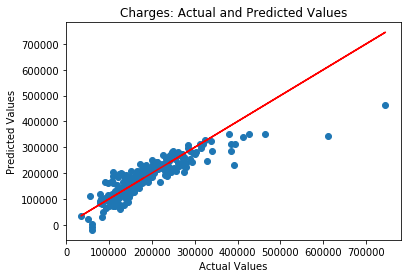

The mean absolute error of the prediction is: 25546.803828588778
The mean squared error of the prediction is: 1559083821.9730272
The root mean squared error of the prediction is: 39485.23549344776
The mean absolute percentage error of the prediction is: 15.551420347537784


In [10]:
# Making predictions:
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Charges: Actual and Predicted Values")
plt.show()

print("The mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("The mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("The root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("The mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Lower values are desirable for all four metrics. The lower the value, the better the performance of the model. These values seem quite high. We will try to improve upon this model by adding some additional variables.

In [12]:
house_df['totalsqft'] = house_df['totalbsmtsf'] + house_df['firstflrsf'] + house_df['secondflrsf']

house_df['totalsqft_overallqual_interaction'] = house_df['totalsqft'] * house_df['overallqual']

# Y is the target variable
Y = np.log1p(house_df['saleprice'])
# X is the feature set
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'garagearea', 'totalsqft', 'totalsqft_overallqual_interaction'] + dummy_column_names]

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

results = sm.OLS(y_train, X_train).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     520.9
Date:                Tue, 06 Aug 2019   Prob (F-statistic):               0.00
Time:                        19:16:16   Log-Likelihood:                 463.99
No. Observations:                1168   AIC:                            -904.0
Df Residuals:                    1156   BIC:                            -843.2
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
const                                 9.9162      0.102     97.518      0.000       9.717      10.116
overallqual                           0.1893      0.009     20.123      0.000       0.171       0.208
grlivarea                           9.58e-05   1.89e-05      5.074      0.000    5.88e-05       0.000
garagecars                            0.0779      0.015      5.244      0.000       0.049       0.107
garagearea                            0.0001   5.04e-05      2.132      0.033    8.57e-06       0.000
totalsqft                             0.0003   2.58e-05     11.139      0.000       0.000       0.000
totalsqft_overallqual_interaction -2.572e-05   3.02e-06     -8.526      0.000   -3.16e-05   -1.98e-05
mszoning_FV                           0.3911      0.065      6.055      0.000       0.264       0.518
mszoning_RH                           0.2650      0.074      3.593      0.000       0.120       0.410
mszoning_RL                           0.3879      0.060      6.481      0.000       0.270       0.505
mszoning_RM                           0.2155      0.061      3.556      0.000       0.097       0.334
street_Pave                          -0.0556      0.075     -0.744      0.457      -0.202       0.091
==============================================================================
Omnibus:                      350.711   Durbin-Watson:                   1.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2714.386
Skew:                          -1.167   Prob(JB):                         0.00
Kurtosis:                      10.094   Cond. No.                     5.33e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The R-squared and adjusted R-squared are 0.832 and 0.831 respectively, a pretty decent improvement over the R-squared of the previous model (0.766). The AIC and BIC are also significantly lower at -904.0 and -843.2 respectively (vs. 27970 and 28020). Overall this model is a better fit than the first model.

### Predicting house prices and evaluating performance

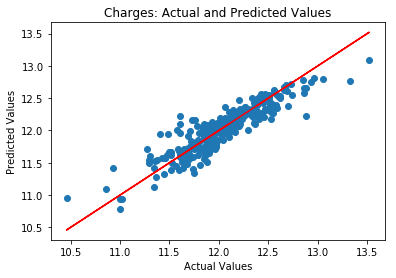

The mean absolute error of the prediction is: 0.12570372872856292
The mean squared error of the prediction is: 0.029192121871319875
The root mean squared error of the prediction is: 0.17085702172085254
The mean absolute percentage error of the prediction is: 1.0503577667820165


In [13]:
# Making predictions:
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Charges: Actual and Predicted Values")
plt.show()

print("The mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("The mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("The root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("The mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

The test set evaluation metrics are significantly lower in this model than they are in our first model. I would now call the performance of my model satisfactory after adding the new variables.